## _Track Evaluation_

- Running _`trkx_from_gnn.py`_ produces recostucted tracks (track candiates)
- Running _`trkx_reco_eval.py`_ gives reconstruction evaluation: _`eff, fake rate, dup. rate, etc`_

Let's perform inspection after track evaluation.

In [1]:
import sys, os, glob, yaml

In [2]:
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import pprint
import seaborn as sns
import trackml.dataset

In [4]:
import torch
from torch_geometric.data import Data
import itertools

In [5]:
sys.path.append('..')

In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

## _A. Inspection of Epsilon in DBSCAN_

1. Various $\epsilon$ for DBSCAN in `trkx_from_gnn.py`
2. Choose the best $\epsilon$ based on _`eff, fake rate, dup. rate`_) after `trkx_reco_eval.py`

**NOTE:** The $\epsilon$ in DBSCAN is alternative to chosing a cut on the `edge_score`.

In [7]:
epsilon = [0.015, 0.025, 0.050, 0.075, 0.1, 0.15, 0.2, 0.25, 0.35, 0.45, 0.55, 0.75, 0.85, 0.95, 1.0]

In [8]:
# Muons: DNN LN
outname="dnn"
eff_phys = [0.1708,8.3673,36.7104,62.9073,70.4835,74.1022,75.7477,76.4197,76.5448,75.8893,74.4427,68.5609,63.3662,52.7343,0.7349]
eff_tech = [0.1747,8.6013,37.2240,64.0621,71.8009,75.4744,77.1188,77.7886,77.9088,77.2419,75.7630,69.7543,64.4568,53.6553,0.7514]
purity   = [5.8608,68.1184,91.0142,95.6769,95.9568,96.0281,95.9904,95.8376,95.3498,94.7540,93.8815,91.3093,89.0565,83.6899,5.9280]
clones   = [4.4050,45.4327,56.3284,41.7467,22.4429,16.5911,14.1281,12.7071,10.7304,9.1478,7.4382,5.0694,4.1512,2.7415,0.1389]

In [9]:
# Muons: IGNN
outname="gnn"
eff_phys = [88.2250, 88.8337, 89.6347, 90.1322, 90.4533, 90.9524, 91.2334, 91.1832, 88.4393, 85.1644, 83.5178, 81.4443, 80.1778, 77.6377, 0.7349]
eff_tech = [89.8331, 90.4563, 91.2791, 91.7934, 92.1251, 92.6372, 92.9258, 92.8686, 90.0497, 86.7017, 85.0175, 82.9097, 81.6185, 79.0440, 0.7514]
purity   = [97.2793, 97.4626, 97.7950, 98.0192, 98.2108, 98.5698, 98.8359, 98.9482, 98.0389, 96.9250, 96.3454, 95.6658, 95.2468, 94.4137, 5.9280]
clones   = [14.9108, 14.2468, 13.3162, 12.7301, 12.2580, 11.4377, 10.4787, 9.0237, 4.5875, 2.3772, 1.7618, 1.3914, 1.3140, 1.2631, 0.1389]

In [10]:
# covert to ndarrays
eff_phys = np.array(eff_phys)
eff_tech = np.array(eff_tech)
purity   = np.array(purity)
clones   = np.array(clones)
epsilon = np.array(epsilon)

In [11]:
# plt.style.use('ggplot')
# mpl.rcParams.update(mpl.rcParamsDefault)

In [12]:
import matplotlib.ticker as ticker

ERROR! Session/line number was not unique in database. History logging moved to new session 5355


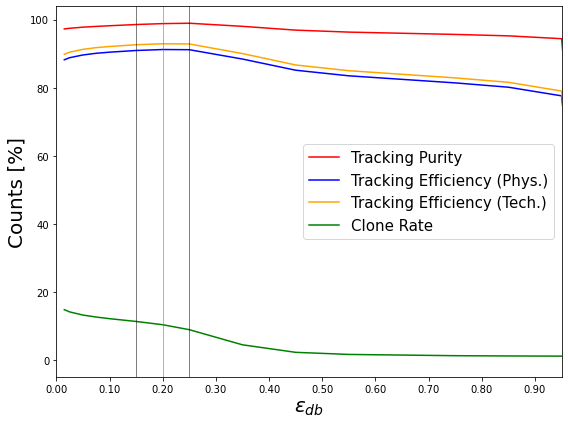

In [47]:
# init subplots
fig, ax = plt.subplots(nrows=1,ncols=1,figsize=(8,6))
ax.plot(epsilon, purity, linestyle='-', linewidth=1.5, color='red', label="Tracking Purity")
ax.plot(epsilon, eff_phys, linestyle='-', linewidth=1.5, color='blue', label="Tracking Efficiency (Phys.)")
ax.plot(epsilon, eff_tech, linestyle='-', linewidth=1.5, color='orange', label="Tracking Efficiency (Tech.)")
ax.plot(epsilon, clones, linestyle='-', linewidth=1.5, color='green', label="Clone Rate")

#plt.axvline(x=0.10, linewidth=0.5, color='k')
plt.axvline(x=0.15, linewidth=0.5, color='k')
plt.axvline(x=0.20, linewidth=0.5, color='magenta')
plt.axvline(x=0.25, linewidth=0.5, color='k')
#plt.axvline(x=0.3, linewidth=0.5, color='magenta')

# plotting params
# ax.set_title('Track evaluation (efficiency vs epsilon)')
ax.set_xlabel(r'$\epsilon_{db}$', fontsize=20)
ax.set_ylabel('Counts [%]', fontsize=20)
ax.set_xlim(0, 0.95)
# ax.set_ylim(0.0, 100)
# ax.set_yscale('log')

start, end = ax.get_xlim()
ax.xaxis.set_ticks(np.arange(start, end, 0.1))
ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%0.2f'))


ax.grid(False)
ax.legend(fontsize=15, loc='best')
fig.tight_layout()
fig.savefig(outname+"_epsilon_scan.pdf")

## _B. Visualize Test Data_

Inspect easy to difficult to reconstruct tracks. Choose 10 such events and use `score_cut=0.25`

In [14]:
from src.drawing import detector_layout, draw_proc_event

In [15]:
inputdir="../run_all/fwp_gnn_processed/pred"
proc_files = sorted(glob.glob(os.path.join(inputdir, "*")))

In [16]:
feature_data = torch.load(proc_files[0], map_location=device)

In [17]:
feature_data

Data(x=[24, 3], pid=[24], layers=[24], event_file='/home/adeak977/current/3_deeptrkx/ctd2022/train_quick/event0000000000', hid=[24], pt=[24], vertex=[24, 3], charge=[24], pdgcode=[24], ptheta=[24], peta=[24], pphi=[24], modulewise_true_edges=[2, 22], layerwise_true_edges=[2, 25], edge_index=[2, 44], y_pid=[44], scores=[88])

In [18]:
event_id = int(os.path.basename(feature_data.event_file)[-4:])

In [19]:
event_id

0

## _(C.) Post Analysis_

- Read evaluation data

In [20]:
sys.path.append('..')

In [21]:
from src.drawing import detector_layout, draw_proc_event
from src.utils_math import polar_to_cartesian

In [22]:
# select event index (glob will fetch events as a list)
event_idx = 1

### _(1.) Read True Tracks_

In [23]:
# get list of true tracks (test dataset)
inputdir="../run_all/fwp_gnn_processed/pred"
true_trkx = sorted(glob.glob(os.path.join(inputdir, "*")))

In [24]:
# event Data
true_track = torch.load(true_trkx[event_idx], map_location=device)
print("Length of Data: {}".format(len(true_track)))

Length of Data: 17


In [25]:
true_track

Data(x=[25, 3], pid=[25], layers=[25], event_file='/home/adeak977/current/3_deeptrkx/ctd2022/train_quick/event0000000001', hid=[25], pt=[25], vertex=[25, 3], charge=[25], pdgcode=[25], ptheta=[25], peta=[25], pphi=[25], modulewise_true_edges=[2, 23], layerwise_true_edges=[2, 25], edge_index=[2, 48], y_pid=[48], scores=[96])

In [26]:
# hit features
r, phi, ir = true_track.x.T

In [27]:
# spatial coordinate transform
x, y = polar_to_cartesian(r.detach().numpy(), phi.detach().numpy())

In [28]:
# compensate scaling
ir = ir.detach().numpy()*100

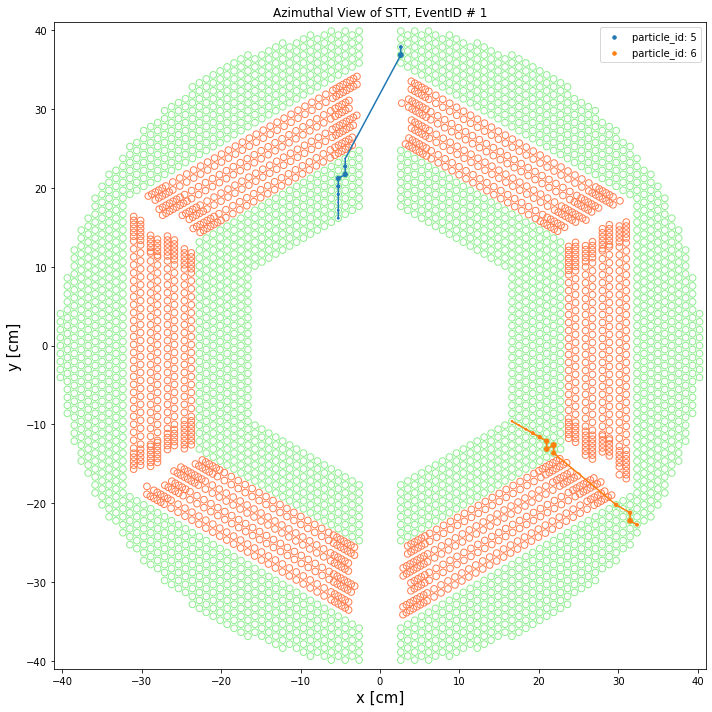

In [29]:
# plot true event
fig, ax = detector_layout(figsize=(10,10))
e_id = int(true_track.event_file[-10:])
p_ids = np.unique(true_track.pid)

for pid in p_ids:
    idx = true_track.pid == pid
    ax.plot(x[idx], y[idx], '-', linewidth=1.5)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*50), label='particle_id: {}'.format(int(pid)))

ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("true_track.png")

### _(2.) Read Reco Track_

In [30]:
inputdir="../run_all/fwp_gnn_segmenting/seg"
reco_trkx = sorted(glob.glob(os.path.join(inputdir, "*")))

In [31]:
print("Track Id: ", reco_trkx[event_idx])

Track Id:  ../run_all/fwp_gnn_segmenting/seg/1


In [32]:
reco_track = torch.load(reco_trkx[event_idx], map_location=device)
print("Length of Data: {}".format(len(reco_track)))

Length of Data: 25


In [33]:
reco_track.head()

,hit_id,track_id
0,23,0
1,24,0
2,25,0
3,26,0
4,27,0


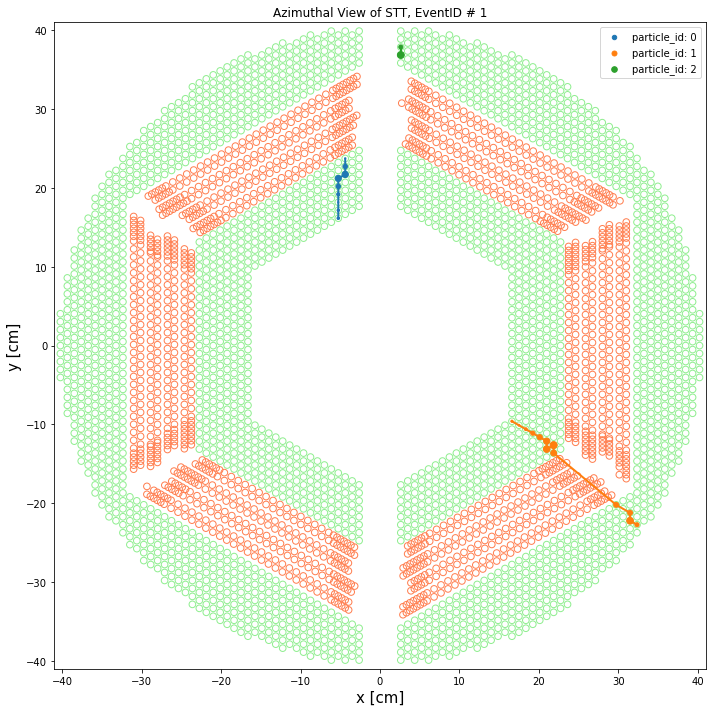

In [34]:
# plot reco event, here, (x,y,ir) comes from ture event. but idx is from reco event
fig, ax = detector_layout(figsize=(10,10))
e_id = e_id
t_ids = np.unique(reco_track.track_id)

for tid in t_ids:
    idx = reco_track.track_id == tid
    ax.plot(x[idx], y[idx], '-', linewidth=2)
    ax.scatter(x[idx], y[idx], s=(ir[idx]*100), label='particle_id: {}'.format(tid))
    
ax.set_title('Azimuthal View of STT, EventID # {}'.format(e_id))
ax.legend(fontsize=10, loc='best')
fig.tight_layout()
# fig.savefig("reco_track.png")

### _(3.) Read Track Evaluation Data_

In [35]:
inputdir="../run_all/fwp_gnn_segmenting/eval"

In [36]:
evtid = int(os.path.split(reco_trkx[1006])[1])

In [37]:
print("evtid: {}".format(evtid))

evtid: 10911


In [38]:
!./eval_reco_evt.sh $evtid

Out of 29703 events processing 1 events with 8 workers
Output directory: /home/adeak977/current/3_deeptrkx/ctd2022_mu/run_all/fwp_gnn_segmenting/eval
Finihed evaluation and saving output to 10911_<filename>


In [39]:
# path to HDF5 Store
hdf5_path = inputdir+"/{}_particles.h5".format(evtid)
print(hdf5_path)

../run_all/fwp_gnn_segmenting/eval/10911_particles.h5


In [40]:
df = pd.read_hdf(hdf5_path)
print("Length of Data: {}".format(len(df)))

Length of Data: 3


In [41]:
df.head()

,particle_id,pt,vx,vy,vz,q,pdgcode,ptheta,peta,pphi,n_true_hits,is_matched,is_trackable,evtid
0,4,0.347001,-0.073392,2.80093,11.25650,-1,-2212,0.385137,1.634835,1.423528,14,True,True,10911
1,5,0.082030,-0.073392,2.80093,11.25650,1,211,0.696260,1.013598,2.743474,6,True,False,10911
2,6,0.152655,0.068595,-2.61787,6.78146,1,2212,0.323681,1.812358,-1.420574,12,True,True,10911


In [42]:
# Read the Summary of Evaluation
sum_path = inputdir+"/{}_summary.txt".format(evtid)
print(sum_path)

../run_all/fwp_gnn_segmenting/eval/10911_summary.txt


In [43]:
with open(sum_path) as f:
    contents = f.read()
    print(contents)

--------------------------------------------------
                    Run Time: 20230324-184102
        Reconstructed tracks: /home/adeak977/current/3_deeptrkx/ctd2022_mu/run_all/fwp_gnn_segmenting/seg
                 # of events:          1
                Truth tracks:          3
        Truth tracks matched:          3
           Truth tracks reco:          2
   Truth tracks reco matched:          2
                Reco. tracks:          3
        Reco. tracks matched:          3
 Reco. tracks matched to POI:          3
     Reco. tracks duplicated:          0
 Tracking Efficiency (Phys.):   100.0000%
 Tracking Efficiency (Tech.):   100.0000%
             Tracking Purity:   100.0000%
                   Fake Rate:     0.0000%
            Duplication Rate:     0.0000%

